## Notbook to do quick testing of core simulator methods

In [2]:
from simulator import *
%matplotlib inline
import math

2025-03-05 02:29:30.806172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 02:29:30.818264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741138170.832103 2017737 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741138170.836253 2017737 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 02:29:30.850958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import tifffile

file_path = '/home/dcorrea/deconvolution/data/tubes/tubes/sample_24.ome.tif'
with tifffile.TiffFile(file_path) as tif:
  data = tif.asarray()

print("Dimensions of the OME-TIFF file:", data.shape)

Dimensions of the OME-TIFF file: (30, 256, 256)


In [4]:
psf = load_data('/home/dcorrea/deconvolution/psf/psf_simple.npy')
print("Dimensions of the PSF:", psf.shape)


Dimensions of the PSF: (101, 256, 256)


# Gaussian Noise

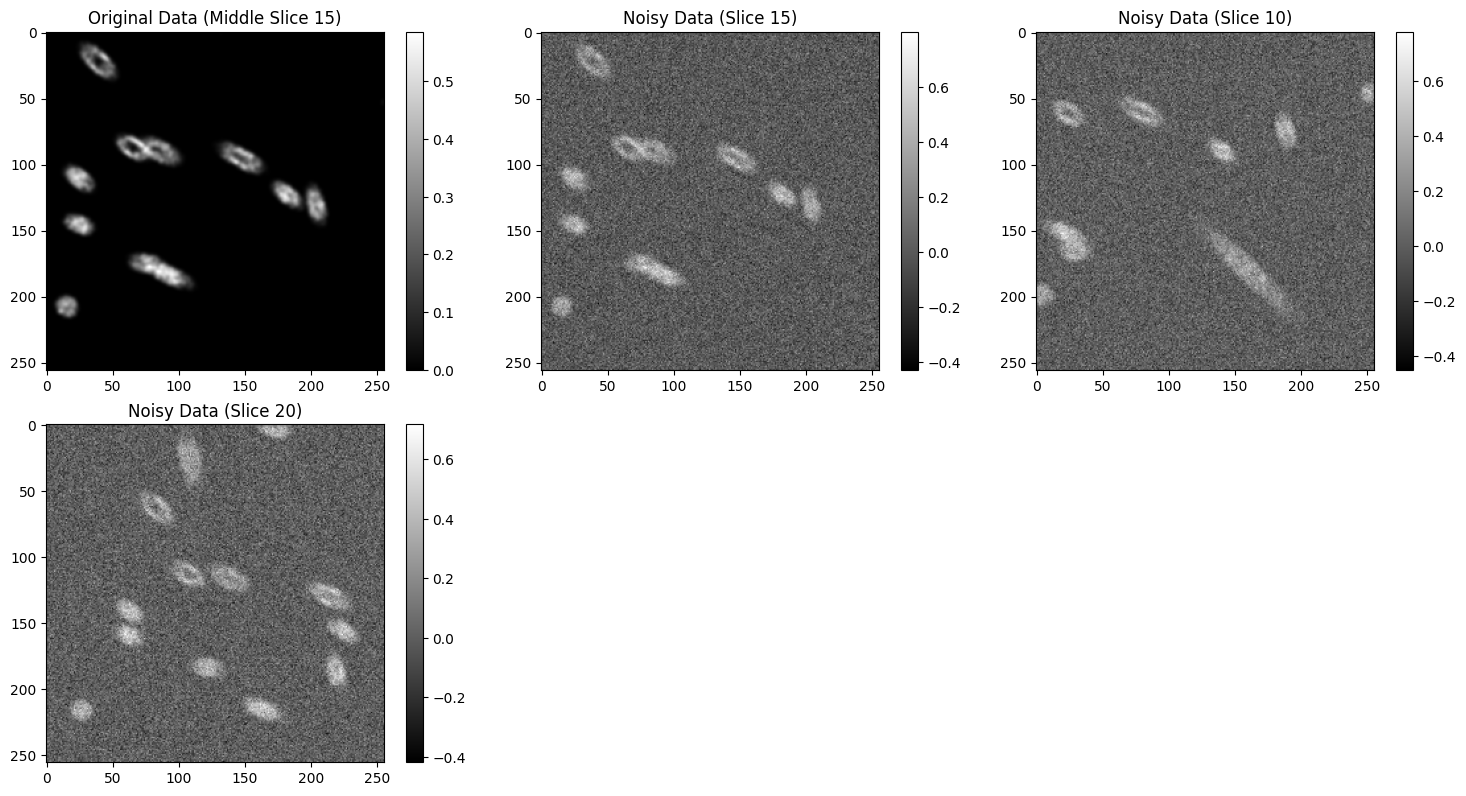

In [5]:
sigma_g = 0.1  # Example Gaussian noise standard deviation

# Apply Gaussian noise to the mock data
noisy_data_gaussian = add_gaussian_noise(data, sigma_g)

# middle slice index of the data (assuming the data is 3D)
middle_slice_index = data.shape[0] // 2

# slices to visualize from the noisy data (can adjust this list)
slices_to_show = [middle_slice_index, middle_slice_index - 5, middle_slice_index + 5]

# Plot the middle slice of the original data and some noisy slices
plt.figure(figsize=(15, 8))

# Original data middle slice
plt.subplot(2, 3, 1)
plt.imshow(data[middle_slice_index, :, :], cmap='gray')
plt.title("Original Data (Middle Slice 15)")
plt.colorbar()

# Noisy data slices
for i, slice_index in enumerate(slices_to_show, 2):
    plt.subplot(2, 3, i)
    plt.imshow(noisy_data_gaussian[slice_index, :, :], cmap='gray')
    plt.title(f"Noisy Data (Slice {slice_index})")
    plt.colorbar()

plt.tight_layout()
plt.show()


# Poisson Noise

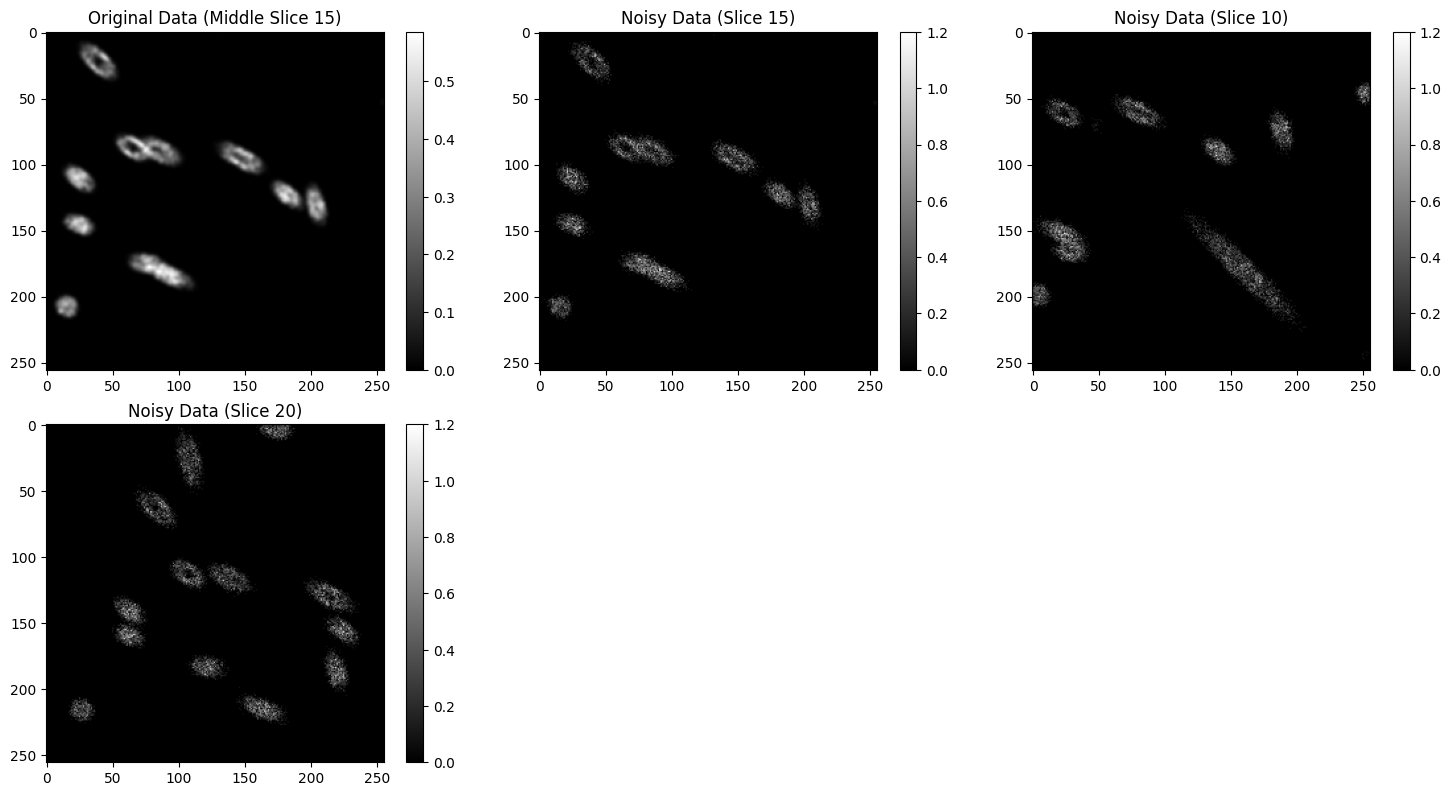

In [6]:
alpha_p = 10  # Example Poisson noise parameter

# Apply Poisson noise to the mock data
noisy_data_poisson = add_poisson_noise(data, alpha_p)

# Plot the middle slice of the original data and some noisy slices
plt.figure(figsize=(15, 8))

# Original data middle slice
plt.subplot(2, 3, 1)
plt.imshow(data[middle_slice_index, :, :], cmap='gray')
plt.title("Original Data (Middle Slice 15)")
plt.colorbar()

# Noisy data slices
for i, slice_index in enumerate(slices_to_show, 2):
    plt.subplot(2, 3, i)
    plt.imshow(noisy_data_poisson[slice_index, :, :], cmap='gray')
    plt.title(f"Noisy Data (Slice {slice_index})")
    plt.colorbar()

plt.tight_layout()
plt.show()

# PSF with same shape (fftconvolve#), in this case PSF is a simple delta function

when convolving with a delta function ( 1 at center and zeros everywhere) the output should be the same as the input

In [12]:
def delta_psf(shape):
    psf = np.zeros(shape, dtype=np.float32)
    center = tuple(s // 2 for s in shape)
    psf[center] = 1.0
    return psf

In [13]:
# Create a delta PSF that matches the shape of your data.
psf_delta = delta_psf(data.shape)
psf_delta.shape

(30, 256, 256)

In [15]:
#test convolution
result = convolution_sample_psf(data, psf_delta)
#result = fftconvolve(data, psf_delta, mode='same')
#result = nd_convolve(data, psf_delta, mode='reflect')

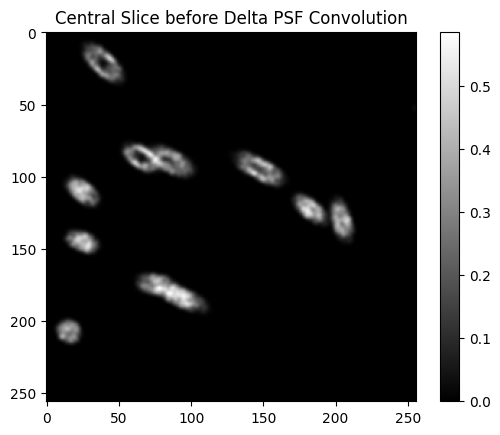

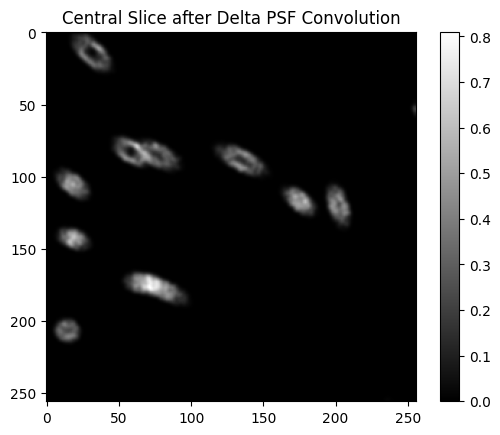

In [16]:
slice_index = data.shape[0] // 2
plt.imshow(data[slice_index, :, :], cmap='gray')
plt.title("Central Slice before Delta PSF Convolution")
plt.colorbar()
plt.show()
plt.imshow(result[slice_index, :, :], cmap='gray')
plt.title("Central Slice after Delta PSF Convolution")
plt.colorbar()
plt.show()


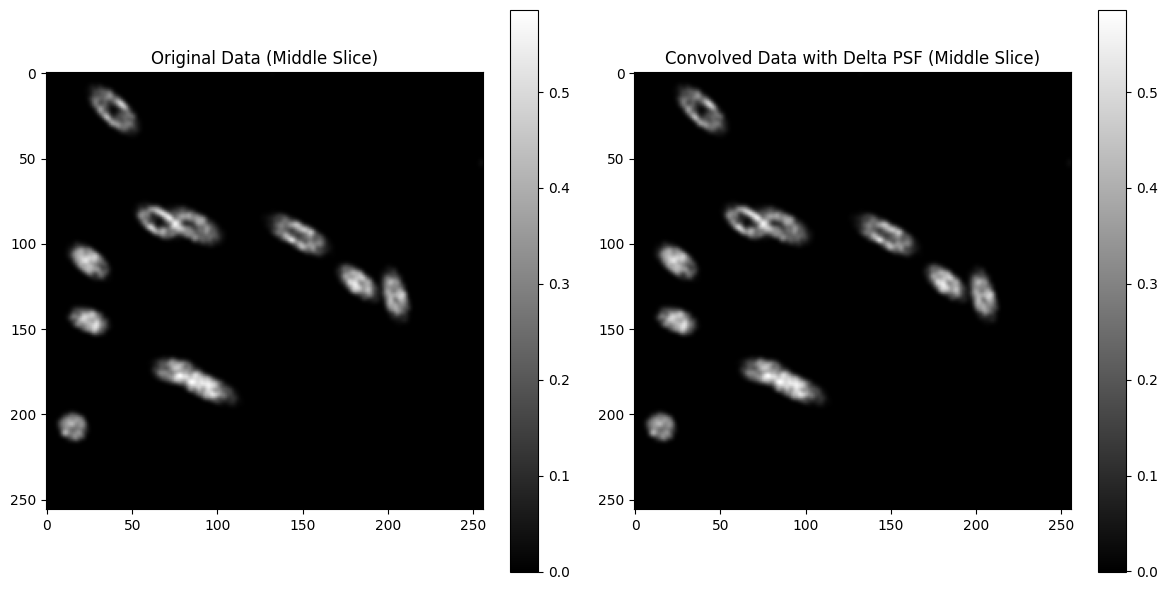

In [ ]:
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt

#  SMALLER9x9x9 delta PSF
psf_shape = (9, 9, 9)
delta_psf = np.zeros(psf_shape)
delta_psf[4, 4, 4] = 1  # Set the center to 1, simulating a delta function

convolved_data = fftconvolve(data, delta_psf, mode='same')

middle_slice_index = data.shape[0] // 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(data[middle_slice_index, :, :], cmap='gray')
plt.title("Original Data (Middle Slice)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(convolved_data[middle_slice_index, :, :], cmap='gray')
plt.title("Convolved Data with Delta PSF (Middle Slice)")
plt.colorbar()

plt.tight_layout()
plt.show()


In [31]:
result.max()

np.float32(0.99999994)

In [32]:
data.max()

np.float32(1.0)

In [44]:
type(data.shape)

tuple

# PSF is a gaussian kernel but different size than the data so tensorflow should be used

In [17]:
def gaussian_kernel_3d(size, sigma):
    """
    Generate a normalized 3D Gaussian kernel.
    """
    x = np.arange(-size//2 + 1, size//2 + 1)
    y = np.arange(-size//2 + 1, size//2 + 1)
    z = np.arange(-size//2 + 1, size//2 + 1)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    kernel = np.exp(-(X**2 + Y**2 + Z**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)


In [18]:
import tensorflow as tf

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


Test 2: Convolution with a 9x9x9 Gaussian PSF.


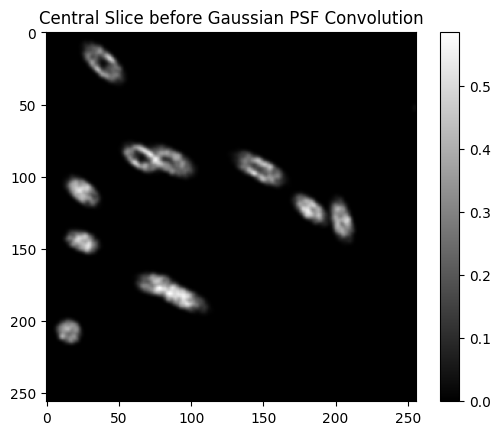

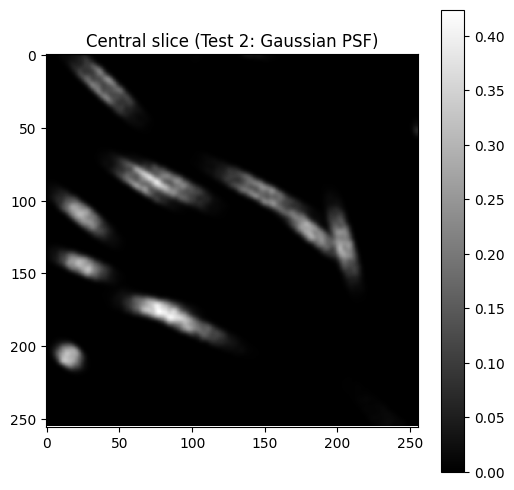

In [19]:

# 3D Gaussian kernel with a size of 9x9x9 and a standard deviation of 1.0.
psf_gaussian = gaussian_kernel_3d(9, 1.0)
# Convolve using the function (this will trigger TensorFlow 3D convolution if shapes differ).
result_diff = convolution_sample_psf(data, psf_gaussian)



slice_index = data.shape[0] // 2
plt.imshow(data[slice_index, :, :], cmap='gray')
plt.title("Central Slice before Gaussian PSF Convolution")
plt.colorbar()

print("Test 2: Convolution with a 9x9x9 Gaussian PSF.")
plt.figure(figsize=(6, 6))
plt.imshow(result_diff[slice_index, :, :], cmap='gray')
plt.title("Central slice (Test 2: Gaussian PSF)")
plt.colorbar()
plt.show()







Test 3: Simulation.


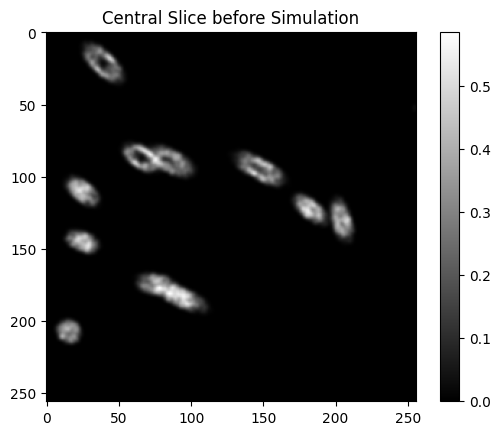

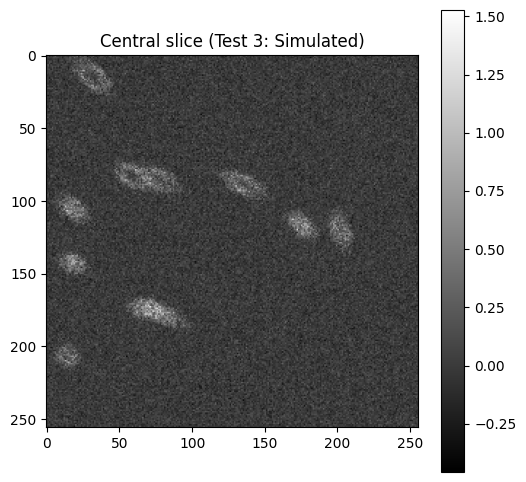

In [20]:
sigma_g = 0.1
alpha_p = 10
background = 0
psf_scale = 1
simulated = simulate_microscopy_image(data, psf_delta, sigma_g, alpha_p, background, psf_scale)

slice_index = data.shape[0] // 2
plt.imshow(data[slice_index, :, :], cmap='gray')
plt.title("Central Slice before Simulation")
plt.colorbar()

print("Test 3: Simulation.")
plt.figure(figsize=(6, 6))
plt.imshow(simulated[slice_index, :, :], cmap='gray')
plt.title("Central slice (Test 3: Simulated)")
plt.colorbar()
plt.show()